In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
from torchvision import datasets, models, transforms
%matplotlib inline

### Loading data

In [7]:
transform = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(299),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'Олег Кравцов - intel_places_ds/seg_{data}/seg_{data}'
image_datasets = {x: datasets.ImageFolder(data_dir.format(data=x),
                                          transform[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=8, pin_memory=True)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Visualizing data

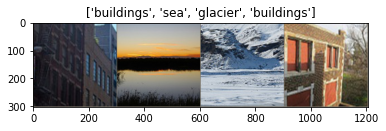

In [8]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### Training model

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    start = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Defining a function for visualizing predictions of mode

In [24]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {} \nactual: {}'.format(class_names[preds[j]], class_names[labels[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### Loading of pre-trained model and fixed feature extractor

In [12]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 6)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### Training and evaluating

In [14]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed a

***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed 

***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed 

***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed 

***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed 

***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed 

***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed 

***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed 

***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed 

***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed 

***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed 

***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed 

***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed 

***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed 

***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed 

***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed 

***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed 

***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed 

***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed 

***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed 

***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed 

***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed 

***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed 

***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed 

***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed 

***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed 

***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed 

***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed 

***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed 

***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed 

***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed 

***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed 

***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed 

***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed 

***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed 

***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed 

***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed 

***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed 

***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed 

***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed 

***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed 

***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed 

***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed 

***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed 

***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed 

***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed 

***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed 

***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed 

***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed 

***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed 

***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed 

***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed 

***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed 

***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed 

***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed 

***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed 

***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed 

***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed an image***
***Passed 

### Predictions vs Actual

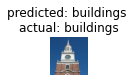

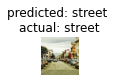

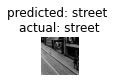

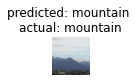

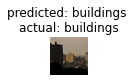

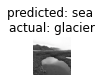

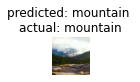

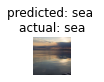

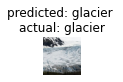

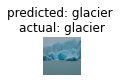

In [25]:
visualize_model(model_conv)

plt.ioff()
plt.show()

### Classification report

In [32]:
from sklearn.metrics import classification_report

def collect_pred_and_true():
    test_acc = 0
    y_true = torch.tensor([]).to(device)
    y_pred = torch.tensor([]).to(device)
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs, labels = inputs.to(device), labels.to(device)
            y_true = torch.cat((y_true, labels), 0)
            preds = model_conv(inputs)
            _, preds = torch.max(preds, 1)
            y_pred = torch.cat((y_pred, preds), 0)

            correct_tensor = preds.eq(labels.data.view_as(preds))
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            test_acc += accuracy.item()* inputs.size(0)
    
    test_acc = 100 * test_acc / dataset_sizes['test']
    print('Testing Accuracy: {acc}%'.format(acc=round(test_acc, 2)))
    return y_pred.cpu().numpy(),  y_true.cpu().numpy()

y_pred, y_true = collect_pred_and_true()
print(classification_report(y_true, y_pred, target_names=class_names))

Testing Accuracy: 88.37%
              precision    recall  f1-score   support

   buildings       0.89      0.88      0.89       437
      forest       1.00      0.92      0.96       474
     glacier       0.88      0.78      0.83       553
    mountain       0.79      0.87      0.83       525
         sea       0.88      0.96      0.92       510
      street       0.89      0.90      0.89       501

    accuracy                           0.88      3000
   macro avg       0.89      0.89      0.89      3000
weighted avg       0.89      0.88      0.88      3000



### ROC curve for implemented model

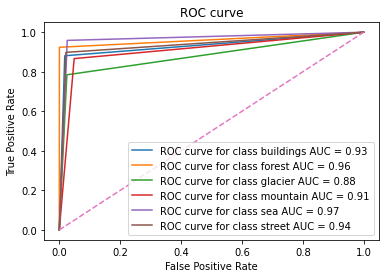

In [33]:
from sklearn.metrics import roc_curve, roc_auc_score, auc

labels_plt = [(y_true == i).astype(float) for i in range(6)]
outs_plt = [(y_pred == i).astype(float) for i in range(6)]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(6):
    fpr[i], tpr[i], _ = roc_curve(labels_plt[i], outs_plt[i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.title('ROC curve')
for i in range(6):
  plt.plot(fpr[i], tpr[i], label = f'ROC curve for class {class_names[i]} AUC = {roc_auc[i]:.2f}' )
plt.legend(loc = 'best')
plt.plot([0,1], [0,1], linestyle='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()